**Imported all the necessary libraries**

In [6]:
!pip install google-api-python-client pandas isodate textblob


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Generating Data from Scratch

Manually entries for the columns youtube_handle from Socialblade into an Excel sheet. Then, uploaded the CSV file and appended the remaining data to it. Extracted the channel_id using the youtube_handle, and used the YouTube API to fetch the rest of the details.

---



In [8]:
import pandas as pd
from googleapiclient.discovery import build
from isodate import parse_duration
import time
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

API_KEY = ""



youtube = build("youtube", "v3", developerKey=API_KEY)

# Load your CSV file
df = pd.read_csv("/content/editing_influencer_enriched_data(2).csv")

# Ensure all required columns exist
columns = [
    "influencer_name","channel_id", "Most_viewd_vedio_url", "Content_Type","total_videos", "upload_frequency_per_Month", "channel_created_year", "avg_views_per_video",
    "avg_likes_per_video", "avg_comments_per_video", "like_to_view_ratio", "comment_to_view_ratio","sentiment_label", "toxicity_score","is_popular_on_twitter","twitter_follower_count"	,
    "is_popular_on_instagram","instagram_follower_count","popularity_label",
    "Virality Score", "GrowthRate_over_time","subscriber_count"
]

for col in columns:
    if col not in df.columns:
        df[col] = None

def extract_channel_id_from_handle(handle):
    try:
        response = youtube.search().list(q=handle, type='channel', part='snippet', maxResults=1).execute()
        return response['items'][0]['snippet']['channelId']
    except Exception:
        return None


# Function to get video comments
def get_video_comments(youtube, video_id, max_comments=30):
    comments = []
    next_page_token = None
    while len(comments) < max_comments:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token,
            textFormat='plainText'
        ).execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
            if len(comments) >= max_comments:
                break

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return comments

# Function to analyze sentiment from comments
def analyze_comment_sentiment(comments):
    if not comments:
        return "neutral", 0.0

    scores = [sia.polarity_scores(comment)['compound'] for comment in comments]
    avg_score = sum(scores) / len(scores)

    label = (
        "positive" if avg_score >= 0.2 else
        "negative" if avg_score <= -0.2 else "neutral"
    )
    return label, round(avg_score, 2)

# Loop over each handle
for index, row in df.iterrows():
    handle = row['youtube_handle']
    channel_id = row.get('channel_id')

    if not pd.notna(channel_id):
        print(f"Fetching channel ID for: {handle}")
        channel_id = extract_channel_id_from_handle(handle)
        if not channel_id:
            print(f"Failed to get channel ID for {handle}")
            continue
        df.at[index, "channel_id"] = channel_id
    else:
        print(f"Channel ID already present for: {handle} ({channel_id})")

    print(f"Enriching data for: {handle}")

    try:
        channel_info = youtube.channels().list(part='snippet,statistics,contentDetails', id=channel_id).execute()
        channel = channel_info['items'][0]

        # Channel Info
        title = channel['snippet']['title']
        created = pd.to_datetime(channel['snippet']['publishedAt'])
        playlist_id = channel['contentDetails']['relatedPlaylists']['uploads']

        df.at[index, "channel_created_year"] = created.year
        df.at[index, "influencer_name"] = title

        # Subscriber count
        try:
            subs = int(channel['statistics'].get('subscriberCount', 0))
            df.at[index, "subscriber_count"] = subs
        except:
            subs = 0
            df.at[index, "subscriber_count"] = "N/A"

        # Total videos
        try:
            total_videos = int(channel['statistics'].get('videoCount', 0))
            df.at[index, "total_videos"] = total_videos
        except:
            total_videos = 0
            df.at[index, "total_videos"] = "N/A"

        # Get top 10 videos
        video_ids, next_token = [], None
        while len(video_ids) < 10:
            playlist_items = youtube.playlistItems().list(
                part='snippet', playlistId=playlist_id, maxResults=10, pageToken=next_token).execute()
            video_ids += [item['snippet']['resourceId']['videoId'] for item in playlist_items['items']]
            next_token = playlist_items.get('nextPageToken')
            if not next_token:
                break
        video_ids = video_ids[:10]

        views, likes, comments, durations = [], [], [], []
        most_viewed_url, max_views = "", -1
        video_categories = []

        for vid in video_ids:
            vdata = youtube.videos().list(part="snippet,statistics,contentDetails", id=vid).execute()
            if not vdata['items']:
                continue
            v = vdata['items'][0]
            stats = v['statistics']
            snippet = v['snippet']
            duration = parse_duration(v['contentDetails']['duration']).total_seconds()
            category_id = snippet.get('categoryId')

            view_ct = int(stats.get('viewCount', 0))
            like_ct = int(stats.get('likeCount', 0))
            comment_ct = int(stats.get('commentCount', 0))

            views.append(view_ct)
            likes.append(like_ct)
            comments.append(comment_ct)
            durations.append(duration)
            if category_id:
                video_categories.append(category_id)

            if view_ct > max_views:
                max_views = view_ct
                most_viewed_url = f"https://www.youtube.com/watch?v={vid}"

        if views:
            avg_views = sum(views) / len(views)
            avg_likes = sum(likes) / len(likes)
            avg_comments = sum(comments) / len(comments)

            df.at[index, "avg_views_per_video"] = avg_views
            df.at[index, "avg_likes_per_video"] = avg_likes
            df.at[index, "avg_comments_per_video"] = avg_comments
            df.at[index, "like_to_view_ratio"] = avg_likes / sum(views)
            df.at[index, "comment_to_view_ratio"] = avg_comments / sum(views)
            df.at[index, "Most_viewd_vedio_url"] = most_viewed_url

        # Content Type
        if video_categories:
            category_info = youtube.videoCategories().list(part="snippet", regionCode="US").execute()
            category_map = {item['id']: item['snippet']['title'] for item in category_info['items']}
            categories = [category_map.get(cid, "Other") for cid in video_categories]
            df.at[index, "Content_Type"] = max(set(categories), key=categories.count)
        else:
            df.at[index, "Content_Type"] = "Unknown"

        # Upload frequency
        years_active = max(1, 2025 - created.year + 1)
        df.at[index, "upload_frequency_per_Month"] = total_videos // (years_active * 12)

        # Sentiment
        comments = get_video_comments(youtube, video_ids[0], max_comments=30)
        sentiment, polarity = analyze_comment_sentiment(comments)
        df.at[index, "sentiment_label"] = sentiment
        df.at[index, "toxicity_score"] = polarity

        # Popularity label
        if subs > 1_000_000 and avg_views > 500_000:
            pop_label = "Viral"
        elif subs > 500_000 or avg_views > 100_000:
            pop_label = "Trending"
        elif subs > 100_000 or avg_views > 10_000:
            pop_label = "Emerging"
        else:
            pop_label = "Niche"
        df.at[index, "popularity_label"] = pop_label

        # Virality Score
        try:
            df.at[index, "Virality Score"] = round((avg_likes / avg_views) * 100, 2)
        except:
            df.at[index, "Virality Score"] = "N/A"

        # Growth Rate
        try:
            df.at[index, "GrowthRate_over_time"] = round((avg_views / (total_videos + 1)), 2)
        except:
            df.at[index, "GrowthRate_over_time"] = "N/A"

        # Save after each row
        df.to_csv("new_influencer_enriched_data_7.csv", index=False)
        print(f"Saved progress for {handle}")
        time.sleep(10)

    except Exception as e:
        print(f"Error processing {handle}: {e}")
        continue


# **Scraping Wikipedia URLs**

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from googleapiclient.discovery import build
import time
import os

# ==== STEP 1: Define Wikipedia URLs ====
wiki_urls = {
      "Australia": "https://en.wikipedia.org/wiki/Category:Australian_YouTubers",
      "Austria": "https://en.wikipedia.org/wiki/Category:Austrian_YouTubers",
      "Bangladesh": "https://en.wikipedia.org/wiki/Category:Bangladeshi_YouTubers",
      "Belarus": "https://en.wikipedia.org/wiki/Category:Belarusian_YouTubers",
      "Belgium": "https://en.wikipedia.org/wiki/Category:Belgian_YouTubers",
      "Bolivia": "https://en.wikipedia.org/wiki/Category:Bolivian_YouTubers",
      "Portugal": "https://pt.wikipedia.org/wiki/Categoria:Youtubers_de_Portugal",
      "India": "https://en.wikipedia.org/wiki/Category:Indian_YouTubers",
      "Japan": "https://en.wikipedia.org/wiki/Category:Japanese_YouTubers",
      "Brazil": "https://en.wikipedia.org/wiki/Category:Brazilian_YouTubers",
      "Germany": "https://en.wikipedia.org/wiki/Category:German_YouTubers",
      "USA": "https://en.wikipedia.org/wiki/Category:American_YouTubers",
      "Russia": "https://en.wikipedia.org/wiki/Category:Russian_YouTubers",
      "Philippines": "https://en.wikipedia.org/wiki/Category:Filipino_YouTubers",
      "South_Korea": "https://en.wikipedia.org/wiki/Category:South_Korean_YouTubers",
      "France": "https://en.wikipedia.org/wiki/Category:French_YouTubers",
      "Spain": "https://en.wikipedia.org/wiki/Category:Spanish_YouTubers",
      "Italy": "https://en.wikipedia.org/wiki/Category:Italian_YouTubers",
      "Mexico": "https://en.wikipedia.org/wiki/Category:Mexican_YouTubers",
      "Indonesia": "https://en.wikipedia.org/wiki/Category:Indonesian_YouTubers",
      "Turkey": "https://en.wikipedia.org/wiki/Category:Turkish_YouTubers",
      "Vietnam": "https://en.wikipedia.org/wiki/Category:Vietnamese_YouTubers",
      "Poland": "https://en.wikipedia.org/wiki/Category:Polish_YouTubers",
      "Canada": "https://en.wikipedia.org/wiki/Category:Canadian_YouTubers",
      "Malaysia": "https://en.wikipedia.org/wiki/Category:Malaysian_YouTubers",
      "Thailand": "https://en.wikipedia.org/wiki/Category:Thai_YouTubers",
      "Switzerland": "https://en.wikipedia.org/wiki/Category:Swiss_YouTubers",
      "Denmark": "https://en.wikipedia.org/wiki/Category:Danish_YouTubers",
      "Netherlands": "https://en.wikipedia.org/wiki/Category:Dutch_YouTubers",
      "Sweden": "https://en.wikipedia.org/wiki/Category:Swedish_YouTubers",
      "Finland": "https://en.wikipedia.org/wiki/Category:Finnish_YouTubers",
      "Ireland": "https://en.wikipedia.org/wiki/Category:Irish_YouTubers",
      "New_Zealand": "https://en.wikipedia.org/wiki/Category:New_Zealand_YouTubers",
      "Israel": "https://en.wikipedia.org/wiki/Category:Israeli_YouTubers",
      "Pakistan": "https://en.wikipedia.org/wiki/Category:Pakistan_YouTubers",
      "Saudi_Arabia": "https://en.wikipedia.org/wiki/Category:Saudi_Arabian_YouTubers",
      "Egypt": "https://en.wikipedia.org/wiki/Category:Egyptian_YouTubers",
      "Colombia": "https://en.wikipedia.org/wiki/Category:Colombian_YouTubers",
      "Peru": "https://en.wikipedia.org/wiki/Category:Peruvian_YouTubers",
      "Venezuela": "https://en.wikipedia.org/wiki/Category:Venezuelan_YouTubers",
      "Guatemala": "https://en.wikipedia.org/wiki/Category:Guatemalan_YouTubers",
      "Cuba": "https://en.wikipedia.org/wiki/Category:Cuban_YouTubers",
      "Ecuador": "https://en.wikipedia.org/wiki/Category:Ecuadorian_YouTubers",
       "China" : "https://en.wikipedia.org/wiki/Category:Chinese_YouTubers",
      "South_Africa": "https://en.wikipedia.org/wiki/Category:South_African_YouTubers",
      "Kenya": "https://en.wikipedia.org/wiki/Category:Kenyan_YouTubers",
      "Nigeria": "https://en.wikipedia.org/wiki/Category:Nigerian_YouTubers",
      "Ghana": "https://en.wikipedia.org/wiki/Category:Ghanaian_YouTubers",
      "Algeria": "https://en.wikipedia.org/wiki/Category:Algerian_YouTubers",
      "Morocco": "https://en.wikipedia.org/wiki/Category:Moroccan_YouTubers",
      "Tunisia": "https://en.wikipedia.org/wiki/Category:Tunisian_YouTubers",
      "Zambia": "https://en.wikipedia.org/wiki/Category:Zambian_YouTubers",
      "Zimbabwe": "https://en.wikipedia.org/wiki/Category:Zimbabwean_YouTubers",
      "Mozambique": "https://en.wikipedia.org/wiki/Category:Mozambican_YouTubers",
      "Botswana": "https://en.wikipedia.org/wiki/Category:Botswanan_YouTubers",
      "Mali": "https://en.wikipedia.org/wiki/Category:Malian_YouTubers",
      "Burkina_Faso": "https://en.wikipedia.org/wiki/Category:Burkinabe_YouTubers",
      "Niger": "https://en.wikipedia.org/wiki/Category:Nigerien_YouTubers",
      "Togo": "https://en.wikipedia.org/wiki/Category:Togolese_YouTubers",
      "Liberia": "https://en.wikipedia.org/wiki/Category:Liberian_YouTubers",
      "Guinea": "https://en.wikipedia.org/wiki/Category:Guinean_YouTubers",
      "Sierra_Leone": "https://en.wikipedia.org/wiki/Category:Sierra_Leonean_YouTubers",
      "Guinea-Bissau": "https://en.wikipedia.org/wiki/Category:Guinea-Bissauan_YouTubers",
      "Benin": "https://en.wikipedia.org/wiki/Category:Beninese_YouTubers",
      "Madagascar": "https://en.wikipedia.org/wiki/Category:Malagasy_YouTubers",
      "Malawi": "https://en.wikipedia.org/wiki/Category:Malawian_YouTubers",
      "Mauritius": "https://en.wikipedia.org/wiki/Category:Mauritian_YouTubers",
      "Seychelles": "https://en.wikipedia.org/wiki/Category:Seychellois_YouTubers",
      "Chad": "https://en.wikipedia.org/wiki/Category:Chadian_YouTubers",
      "Eritrea": "https://en.wikipedia.org/wiki/Category:Eritrean_YouTubers",
      "Somalia": "https://en.wikipedia.org/wiki/Category:Somali_YouTubers",
      "Djibouti": "https://en.wikipedia.org/wiki/Category:Djiboutian_YouTubers",
      "Ethiopia": "https://en.wikipedia.org/wiki/Category:Ethiopian_YouTubers",
      "Rwanda": "https://en.wikipedia.org/wiki/Category:Rwandan_YouTubers",
      "Burundi": "https://en.wikipedia.org/wiki/Category:Burundian_YouTubers",
      "Cameroon": "https://en.wikipedia.org/wiki/Category:Cameroonian_YouTubers",
      "Sudan": "https://en.wikipedia.org/wiki/Category:Sudanese_YouTubers",
      "Congo": "https://en.wikipedia.org/wiki/Category:Congolese_YouTubers",
      "Senegal": "https://en.wikipedia.org/wiki/Category:Senegalese_YouTubers",
}

# ==== STEP 2: YouTube API Setup ====
API_KEY = ""   #
youtube = build("youtube", "v3", developerKey=API_KEY)

# ==== STEP 3: Output File Setup ====
output_file = "all_youtubers_with_handles (1).csv"

if not os.path.exists(output_file):
    df_header = pd.DataFrame(columns=["influencer_name", "country", "youtube_handle", "channel_id"])
    df_header.to_csv(output_file, index=False)

# Load already processed names to skip
processed = set()
existing_df = pd.read_csv(output_file)
for _, row in existing_df.iterrows():
    processed.add((row["influencer_name"], row["country"]))

# ==== STEP 4: Function to Get Channel Info ====
def get_channel_id_and_handle(name):
    try:
        response = youtube.search().list(
            q=name,
            type='channel',
            part='snippet',
            maxResults=1
        ).execute()
        items = response.get('items', [])
        if items:
            channel_id = items[0]['id']['channelId']
            channel_details = youtube.channels().list(part="snippet", id=channel_id).execute()
            custom_url = channel_details['items'][0]['snippet'].get('customUrl')
            handle = f"@{custom_url}" if custom_url else f"https://www.youtube.com/channel/{channel_id}"
            return channel_id, handle
    except Exception as e:
        print(f" Error for {name}: {e}")
    return None, None

# ==== STEP 5: Process Countries ====
for country, url in wiki_urls.items():
    print(f"\n Processing: {country}")
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        youtuber_tags = soup.select("div.mw-category a")
        names = [tag.text.strip() for tag in youtuber_tags]

        for name in names:
            if (name, country) in processed:
                print(f" Skipping already processed: {name} ({country})")
                continue

            print(f" {name} ({country})")
            channel_id, handle = get_channel_id_and_handle(name)
            if channel_id:
                print(f"Found: {handle}")
            else:
                print(f" Not found")

            row = {
                "influencer_name": name,
                "country": country,
                "youtube_handle": handle,
                "channel_id": channel_id
            }

            # Append new row
            pd.DataFrame([row]).to_csv(output_file, mode='a', header=False, index=False)
            processed.add((name, country))  # Add to processed set
            time.sleep(2)  # Respect rate limits

    except Exception as e:
        print(f" Failed to process {country}: {e}")

print(f"\nFinished! Data saved to '{output_file}'")


Read csv file

In [10]:
df=pd.read_csv("/content/influencer_data.csv")
df.head()

,YT Handle,Influencer Name,Channel ID,Creator Country,Subscriber Count,Total Videos,Channel Created Year,Monthly Upload Frequency,Most Viewed Video URL,Content Type,...,Comment Rate (%),Audience Sentiment,Toxicity Score,Virality Score,Growth Rate Over Time,Popularity Category Label,Popular on Twitter,Twitter Followers Count,Popular on Instagram,Instagram Followers Count
0,@mrbeast,MrBeast,UCX6OQ3DkcsbYNE6H8uQQuVA,USA,402000000,875,2012.0,5.0,https://www.youtube.com/watch?v=N0pwLtonPdg,Entertainment,...,0.000029,neutral,0.08,2.27,129814.06,Viral,Highly popular,45900000.0,Highly popular,115000000
1,@stokestwins,Stokes Twins,UCbp9MyKCTEww4CxEzc_Tp0Q,USA,126000000,369,2008.0,1.0,https://www.youtube.com/watch?v=RAdU_ubUxGk,People & Blogs,...,0.000005,neutral,0.06,1.41,113059.48,Viral,Less popular,1500000.0,popular,6100000
2,@alanchikinchow,Alan's Universe,UC5gxP-2QqIh_09djvlm9Xcg,USA,93000000,1400,2020.0,0.0,https://www.youtube.com/watch?v=U2yTes7GON0,Entertainment,...,0.000008,neutral,0.09,1.91,11134395.20,Viral,Less popular,500000.0,Highly popular,20000000
3,@a4a4a4a4,A4,UC2tsySbe9TNrI-xh2lximHA,USA,81000000,1000,2014.0,0.0,https://www.youtube.com/watch?v=amtp6BJhQCc,Entertainment,...,0.000015,neutral,-0.02,2.13,43308246.60,Viral,Less popular,300000.0,Highly popular,10000000
4,@markrober,Mark Rober,UCY1kMZp36IQSyNx_9h4mpCg,USA,69000000,214,2011.0,1.0,https://www.youtube.com/watch?v=tt_l_-5_8WU,Science & Technology,...,0.000015,neutral,0.00,2.95,100971.26,Viral,Highly popular,1000000.0,Highly popular,3500000


Descriptive Statistics

In [11]:
df.describe()

,Subscriber Count,Total Videos,Channel Created Year,Monthly Upload Frequency,Avg Views per Video,Avg Likes per Video,Avg Comments per Video,Like Rate (%),Comment Rate (%),Toxicity Score,Virality Score,Growth Rate Over Time,Twitter Followers Count
count,4.633000e+03,4.633000e+03,4632.000000,4546.000000,4.554000e+03,4.554000e+03,4.554000e+03,4546.000000,4546.000000,4151.000000,4151.000000,4.151000e+03,4.633000e+03
mean,3.275639e+06,1.325670e+03,2016.800086,6.679278,7.588844e+05,2.362991e+04,3.119375e+03,0.005331,0.001109,0.109441,3.636504,1.320976e+05,2.497560e+05
std,1.174592e+07,2.950438e+04,4.829659,17.648919,6.832120e+06,2.960625e+05,1.550848e+05,0.026920,0.024531,0.198159,5.034184,3.011453e+06,1.491932e+06
min,0.000000e+00,0.000000e+00,2005.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,-0.840000,0.000000,0.000000e+00,0.000000e+00
25%,2.140000e+03,6.200000e+01,2013.000000,0.000000,1.011300e+03,1.790000e+01,1.200000e+00,0.001492,0.000040,0.000000,1.545000,6.865000e+00,0.000000e+00
50%,1.560000e+05,2.870000e+02,2017.000000,2.000000,1.341700e+04,3.407167e+02,2.055000e+01,0.002774,0.000148,0.010000,2.800000,5.004000e+01,0.000000e+00
75%,1.550000e+06,8.760000e+02,2020.000000,7.000000,1.403381e+05,3.986250e+03,1.818000e+02,0.004643,0.000385,0.190000,4.560000,4.668350e+02,5.000000e+04
max,4.020000e+08,2.000000e+06,2025.000000,528.000000,3.643823e+08,1.798274e+07,1.045902e+07,1.000000,1.583333,0.980000,200.220000,1.821912e+08,4.590000e+07


In [12]:
df.describe(include='object')

,YT Handle,Influencer Name,Channel ID,Creator Country,Most Viewed Video URL,Content Type,Audience Sentiment,Popularity Category Label,Popular on Twitter,Popular on Instagram,Instagram Followers Count
count,4633,4633,4633,4633,4546,4546,4151,4151,4625,4625,4633
unique,4453,4223,4353,105,4292,15,3,4,7,8,120
top,@TheAnimeMan,Mobile Review,UCucot-Zp428OwkyRm2I7v2Q,USA,https://www.youtube.com/watch?v=GSj053tGDNs,People & Blogs,neutral,Niche,No account,Less popular,50000
freq,4,18,4,1020,3,1152,3077,1518,2727,3048,2667


Display Rows and Columns

In [13]:
print('Number of rows:',df.shape[0])
print('Number of columns:',df.shape[1])
df.shape

Number of rows: 4633
Number of columns: 24


(4633, 24)

Info about dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4633 entries, 0 to 4632
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YT Handle                  4633 non-null   object 
 1   Influencer Name            4633 non-null   object 
 2   Channel ID                 4633 non-null   object 
 3   Creator Country            4633 non-null   object 
 4   Subscriber Count           4633 non-null   int64  
 5   Total Videos               4633 non-null   int64  
 6   Channel Created Year       4632 non-null   float64
 7   Monthly Upload Frequency   4546 non-null   float64
 8   Most Viewed Video URL      4546 non-null   object 
 9   Content Type               4546 non-null   object 
 10  Avg Views per Video        4554 non-null   float64
 11  Avg Likes per Video        4554 non-null   float64
 12  Avg Comments per Video     4554 non-null   float64
 13  Like Rate (%)              4546 non-null   float

In [15]:
df.dtypes

,0
YT Handle,object
Influencer Name,object
Channel ID,object
Creator Country,object
Subscriber Count,int64
Total Videos,int64
Channel Created Year,float64
Monthly Upload Frequency,float64
Most Viewed Video URL,object
Content Type,object


Duplicate Rows

In [16]:
df.duplicated().sum()

np.int64(7)

In [17]:
df.drop_duplicates(inplace=True)

droping irrrelevant column


In [18]:
df.drop(columns=['YT Handle','Channel ID','Most Viewed Video URL'], axis=1, inplace=True)

In [19]:
df.columns

Index(['Influencer Name', 'Creator Country', 'Subscriber Count',
       'Total Videos', 'Channel Created Year', 'Monthly Upload Frequency',
       'Content Type', 'Avg Views per Video', 'Avg Likes per Video',
       'Avg Comments per Video', 'Like Rate (%)', 'Comment Rate (%)',
       'Audience Sentiment', 'Toxicity Score', 'Virality Score',
       'Growth Rate Over Time', 'Popularity Category Label',
       'Popular on Twitter', 'Twitter Followers Count', 'Popular on Instagram',
       'Instagram Followers Count'],
      dtype='object')

 Bar Graph – Missing Values per Column

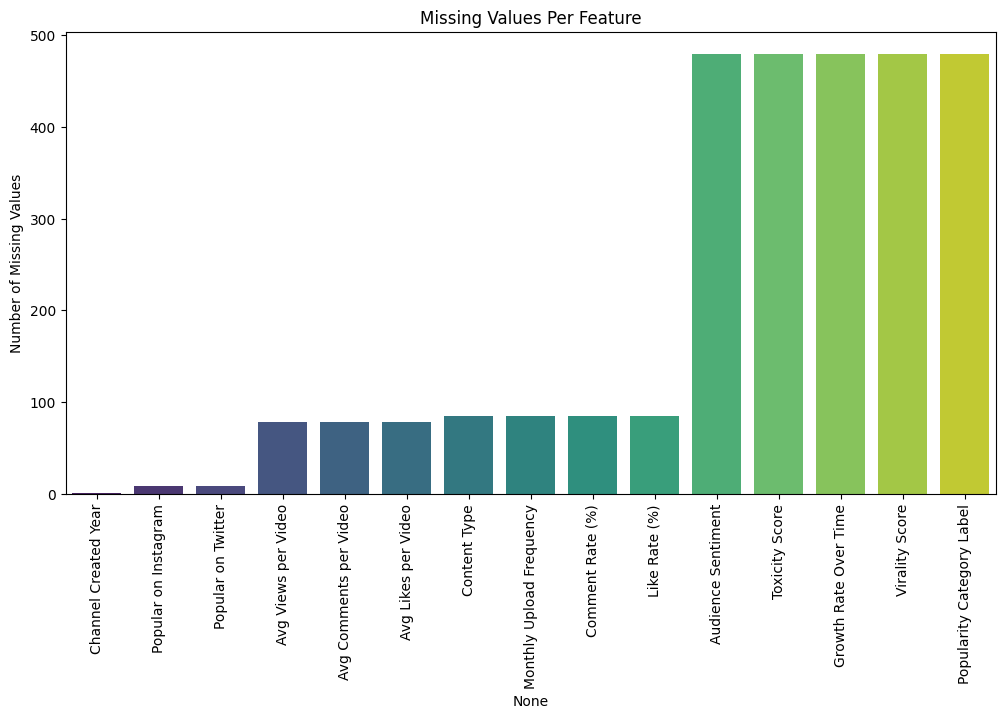

In [20]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(12, 6))
missing_values = missing_values.sort_values(ascending=True)
sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index, palette="viridis", dodge=False, legend=False)
plt.xticks(rotation=90)
plt.ylabel("Number of Missing Values")
plt.title("Missing Values Per Feature")
plt.show()

Dropping rows with missing values

In [21]:
df.dropna(subset=['Popularity Category Label','Popular on Twitter'], inplace=True)

In [22]:
df.isna().sum()

,0
Influencer Name,0
Creator Country,0
Subscriber Count,0
Total Videos,0
Channel Created Year,0
Monthly Upload Frequency,0
Content Type,0
Avg Views per Video,0
Avg Likes per Video,0
Avg Comments per Video,0


**after dropping data with missing values**

In [23]:
print('Number of rows:',df.shape[0])
print('Number of columns:',df.shape[1])
df.shape

Number of rows: 4145
Number of columns: 21


(4145, 21)

# **Outliers**


 Box Plot – Identification of Outliers in Numerical Features

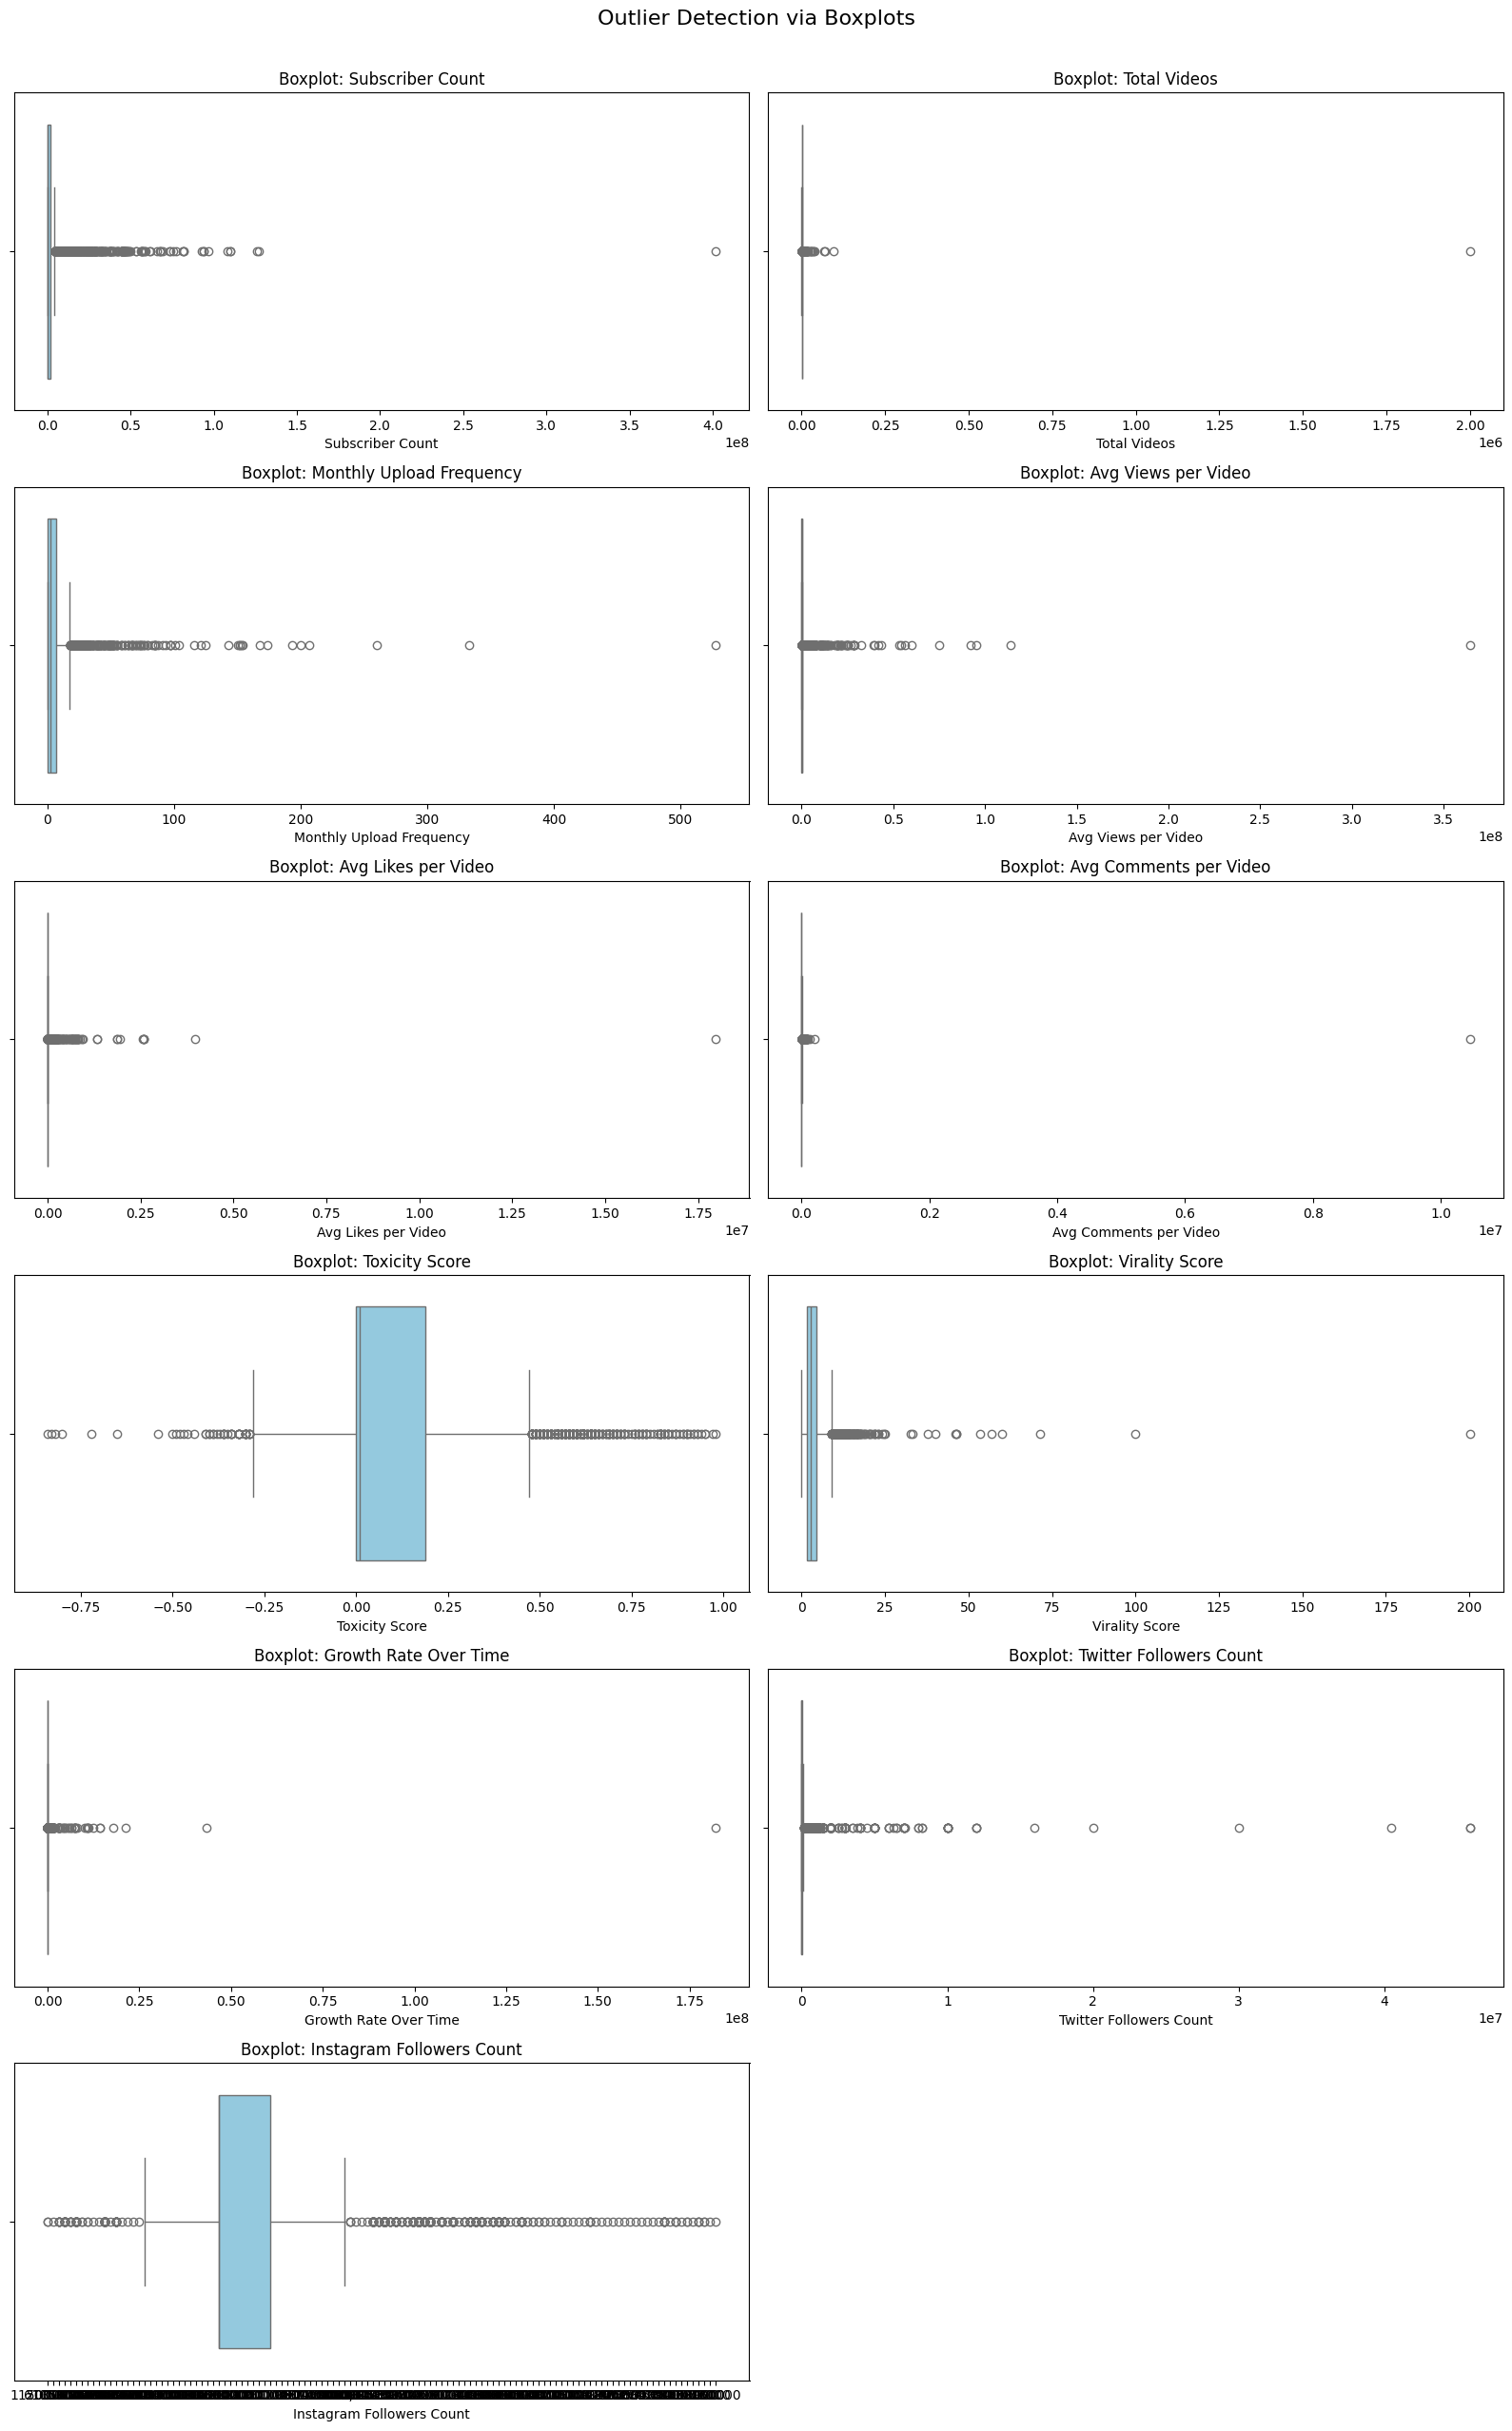

In [24]:
num_cols = [
    'Subscriber Count', 'Total Videos', 'Monthly Upload Frequency',
    'Avg Views per Video', 'Avg Likes per Video', 'Avg Comments per Video',
    'Toxicity Score', 'Virality Score', 'Growth Rate Over Time',
    'Twitter Followers Count', 'Instagram Followers Count'
]

plt.figure(figsize=(16, 25))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//2 + 1, 2, i+1)
    sns.boxplot(data=df, x=col, color='skyblue')
    plt.title(f"Boxplot: {col}", fontsize=12)
    plt.tight_layout()

plt.suptitle("Outlier Detection via Boxplots", fontsize=16, y=1.02)
plt.show()


not removing outliers because this is influencer population data, and naturally, there are very high and very low values

# **Feature Engineering**

**Engagement Rate**

In [25]:
df['Engagement Rate'] = (
    (df['Avg Likes per Video'] + df['Avg Comments per Video']) /
    df['Subscriber Count'].replace(0, np.nan)
)

**Account Age**

In [26]:
df['Account Age'] = 2025 - df['Channel Created Year']

**Post Frequency**

In [27]:
df['Post Frequency'] = df['Total Videos'] / df['Account Age'].replace(0, np.nan)

In [28]:
df.columns

Index(['Influencer Name', 'Creator Country', 'Subscriber Count',
       'Total Videos', 'Channel Created Year', 'Monthly Upload Frequency',
       'Content Type', 'Avg Views per Video', 'Avg Likes per Video',
       'Avg Comments per Video', 'Like Rate (%)', 'Comment Rate (%)',
       'Audience Sentiment', 'Toxicity Score', 'Virality Score',
       'Growth Rate Over Time', 'Popularity Category Label',
       'Popular on Twitter', 'Twitter Followers Count', 'Popular on Instagram',
       'Instagram Followers Count', 'Engagement Rate', 'Account Age',
       'Post Frequency'],
      dtype='object')

In [29]:
df.head()

,Influencer Name,Creator Country,Subscriber Count,Total Videos,Channel Created Year,Monthly Upload Frequency,Content Type,Avg Views per Video,Avg Likes per Video,Avg Comments per Video,...,Virality Score,Growth Rate Over Time,Popularity Category Label,Popular on Twitter,Twitter Followers Count,Popular on Instagram,Instagram Followers Count,Engagement Rate,Account Age,Post Frequency
0,MrBeast,USA,402000000,875,2012.0,5.0,Entertainment,113717113.3,2586568.9,33567.3,...,2.27,129814.06,Viral,Highly popular,45900000.0,Highly popular,115000000,0.006518,13.0,67.307692
1,Stokes Twins,USA,126000000,369,2008.0,1.0,People & Blogs,41832007.8,588640.7,1898.9,...,1.41,113059.48,Viral,Less popular,1500000.0,popular,6100000,0.004687,17.0,21.705882
2,Alan's Universe,USA,93000000,1400,2020.0,0.0,Entertainment,11134395.2,212506.1,838.8,...,1.91,11134395.20,Viral,Less popular,500000.0,Highly popular,20000000,0.002294,5.0,280.000000
3,A4,USA,81000000,1000,2014.0,0.0,Entertainment,43308246.6,924183.1,6387.8,...,2.13,43308246.60,Viral,Less popular,300000.0,Highly popular,10000000,0.011489,11.0,90.909091
4,Mark Rober,USA,69000000,214,2011.0,1.0,Science & Technology,21708819.9,640232.9,3160.3,...,2.95,100971.26,Viral,Highly popular,1000000.0,Highly popular,3500000,0.009325,14.0,15.285714


# **Min-Max Scaling**

In [30]:
from sklearn.preprocessing import MinMaxScaler

df['Instagram Followers Count'] = pd.to_numeric(df['Instagram Followers Count'], errors='coerce')

scale_cols = ['Subscriber Count', 'Avg Views per Video', 'Avg Likes per Video',
              'Avg Comments per Video', 'Virality Score', 'Growth Rate Over Time',
              'Engagement Rate', 'Post Frequency', 'Toxicity Score',
              'Twitter Followers Count', 'Instagram Followers Count']

scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])


In [31]:
df.head()

,Influencer Name,Creator Country,Subscriber Count,Total Videos,Channel Created Year,Monthly Upload Frequency,Content Type,Avg Views per Video,Avg Likes per Video,Avg Comments per Video,...,Virality Score,Growth Rate Over Time,Popularity Category Label,Popular on Twitter,Twitter Followers Count,Popular on Instagram,Instagram Followers Count,Engagement Rate,Account Age,Post Frequency
0,MrBeast,USA,1.000000,875,2012.0,5.0,Entertainment,0.312082,0.143836,0.003209,...,0.011338,0.000713,Viral,Highly popular,1.000000,Highly popular,0.539906,0.000073,13.0,0.000437
1,Stokes Twins,USA,0.313433,369,2008.0,1.0,People & Blogs,0.114803,0.032734,0.000182,...,0.007042,0.000621,Viral,Less popular,0.032680,popular,0.028638,0.000052,17.0,0.000141
2,Alan's Universe,USA,0.231343,1400,2020.0,0.0,Entertainment,0.030557,0.011817,0.000080,...,0.009540,0.061114,Viral,Less popular,0.010893,Highly popular,0.093897,0.000026,5.0,0.001820
3,A4,USA,0.201493,1000,2014.0,0.0,Entertainment,0.118854,0.051393,0.000611,...,0.010638,0.237708,Viral,Less popular,0.006536,Highly popular,0.046948,0.000128,11.0,0.000591
4,Mark Rober,USA,0.171642,214,2011.0,1.0,Science & Technology,0.059577,0.035603,0.000302,...,0.014734,0.000554,Viral,Highly popular,0.021786,Highly popular,0.016432,0.000104,14.0,0.000099


In [32]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)


Numerical Columns: ['Subscriber Count', 'Total Videos', 'Channel Created Year', 'Monthly Upload Frequency', 'Avg Views per Video', 'Avg Likes per Video', 'Avg Comments per Video', 'Like Rate (%)', 'Comment Rate (%)', 'Toxicity Score', 'Virality Score', 'Growth Rate Over Time', 'Twitter Followers Count', 'Instagram Followers Count', 'Engagement Rate', 'Account Age', 'Post Frequency']
Categorical Columns: ['Influencer Name', 'Creator Country', 'Content Type', 'Audience Sentiment', 'Popularity Category Label', 'Popular on Twitter', 'Popular on Instagram']


Most influencers post casually,the data shows influencers upload between 0 and 50 videos per month while others do not upload frequently.

# **Univariate Analysis**

Histograms – Distribution of Numerical Columns

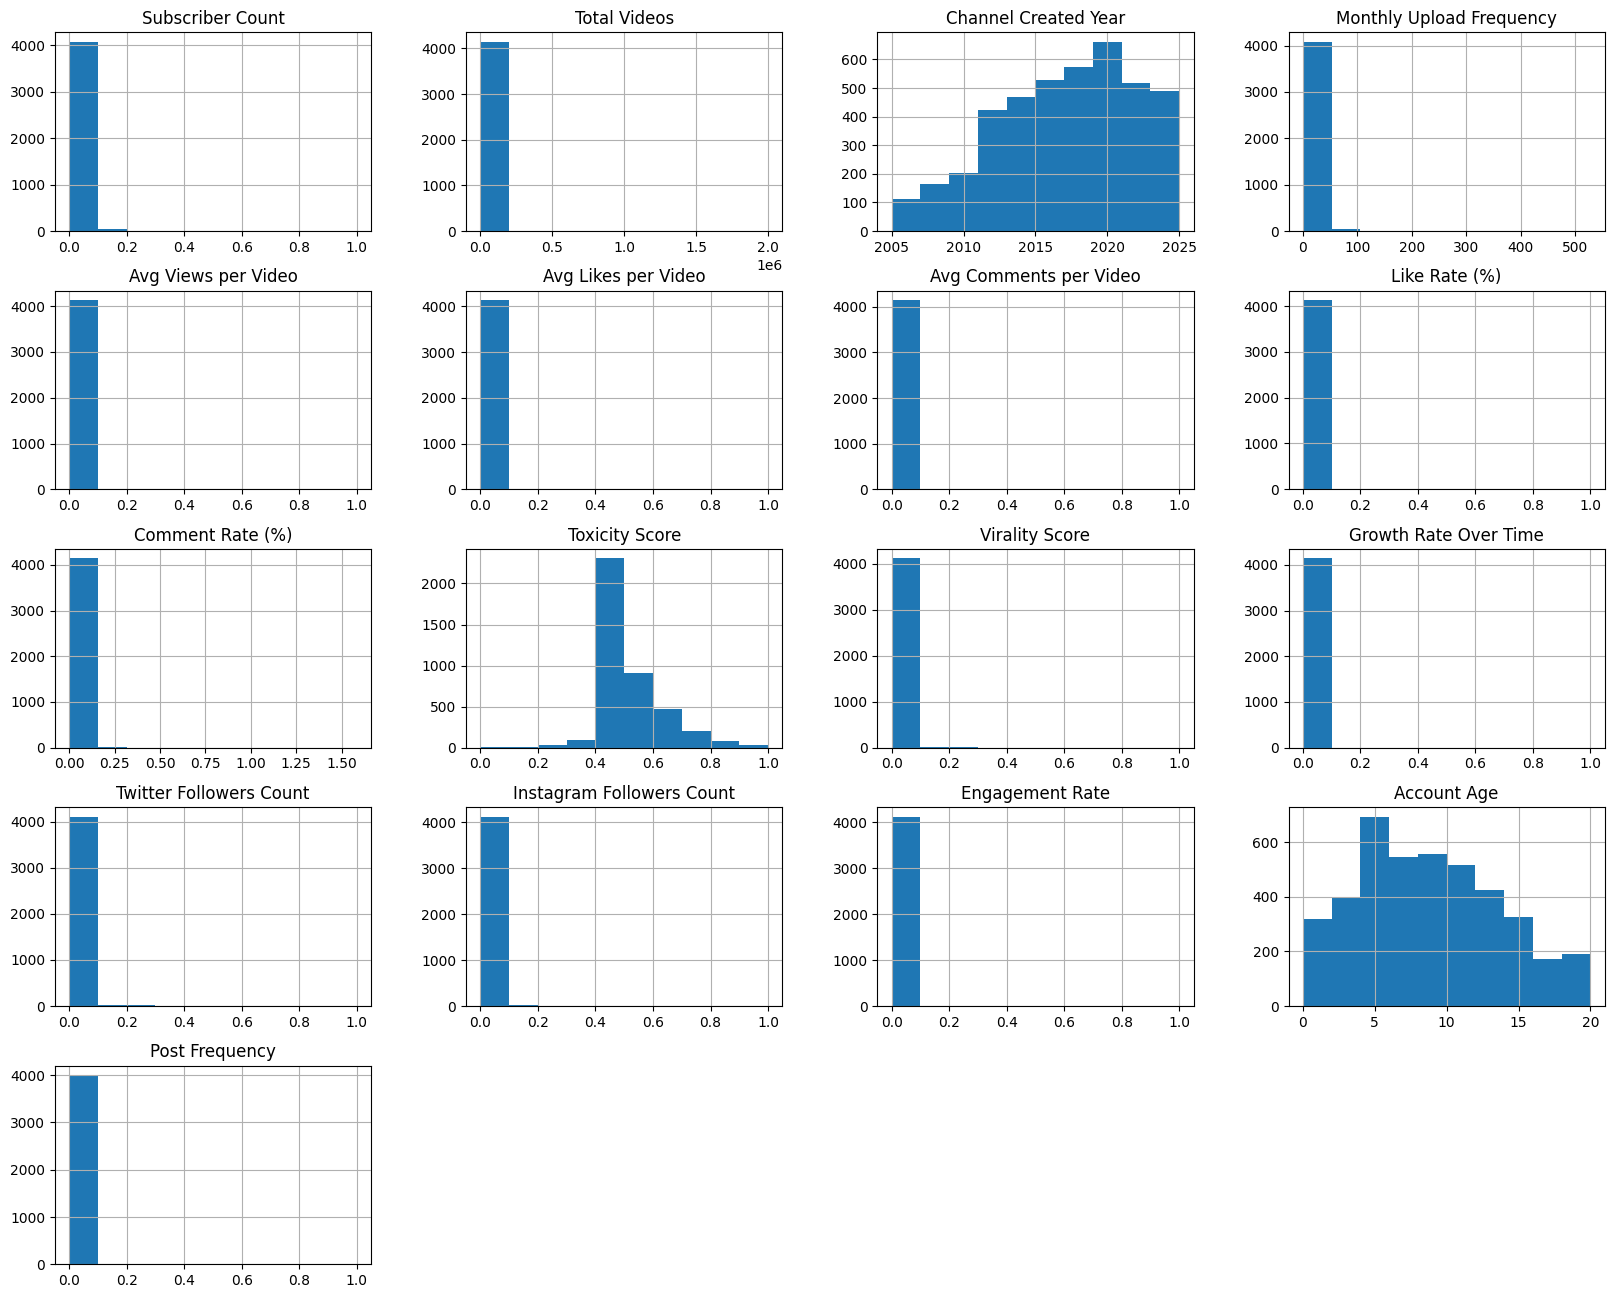

In [33]:
df.hist(figsize=[20,16])
plt.show()

Violinplot : Monthly Upload Frequency

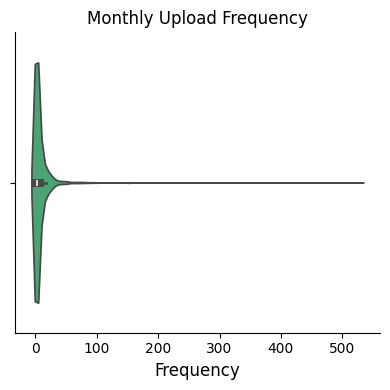

In [34]:
plt.figure(figsize=(4, 4))
sns.violinplot(x=df['Monthly Upload Frequency'], color='mediumseagreen')
plt.title("Monthly Upload Frequency")
plt.xlabel("Frequency", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


**Countplot**

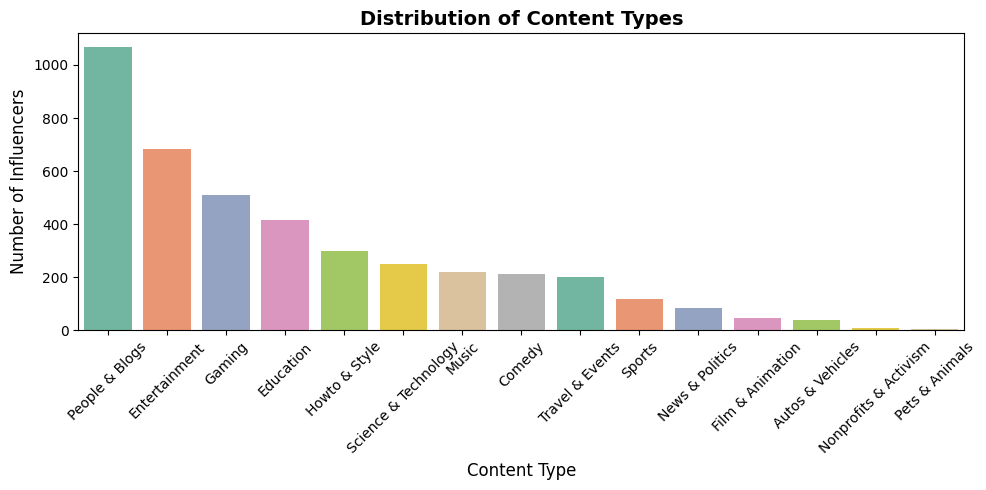

In [35]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Content Type', order=df['Content Type'].value_counts().index, palette='Set2')
plt.title("Distribution of Content Types", fontsize=14, weight='bold')
plt.xlabel("Content Type", fontsize=12)
plt.ylabel("Number of Influencers", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Bar Graph for Categorical**

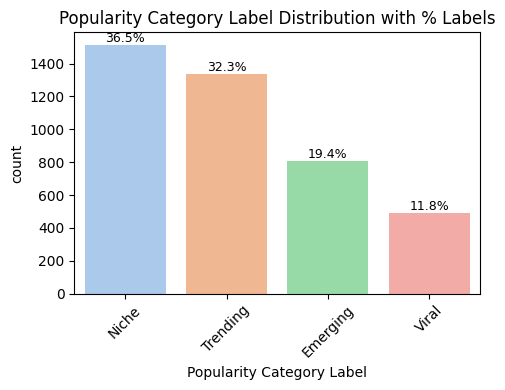

In [36]:
for col in ['Popularity Category Label']:
    plt.figure(figsize=(5, 4))
    order = df[col].value_counts().index
    ax = sns.countplot(x=col, data=df, order=order, palette='pastel')

    total = len(df[col])
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=9, color='black')

    plt.title(f'{col} Distribution with % Labels')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# **Bivariate Analysis**

**Country vs Popularity**

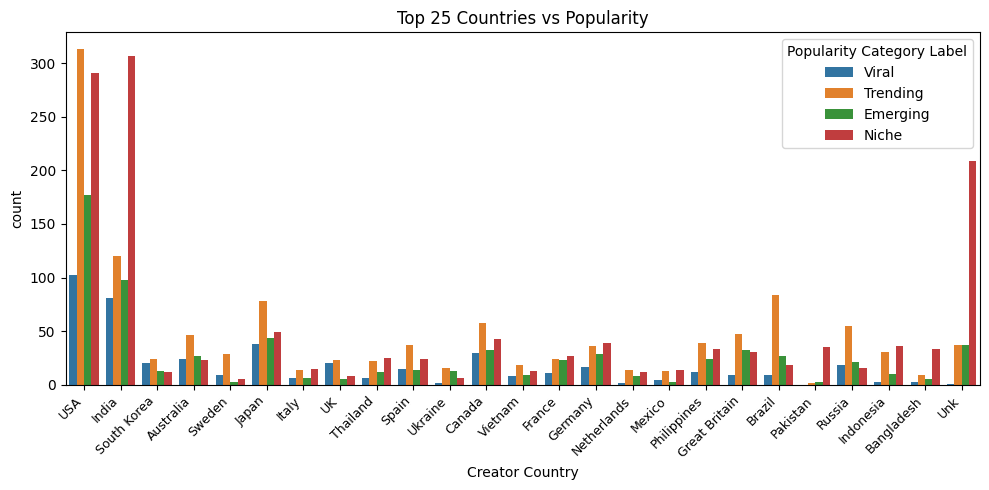

In [37]:
top_n = 25
top_countries = df['Creator Country'].value_counts().nlargest(top_n).index

plt.figure(figsize=(10, 5))
sns.countplot(data=df[df['Creator Country'].isin(top_countries)],
              x='Creator Country', hue='Popularity Category Label')
plt.title(f"Top {top_n} Countries vs Popularity")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()


Stacked bar :Content Type vs Audience Sentiment

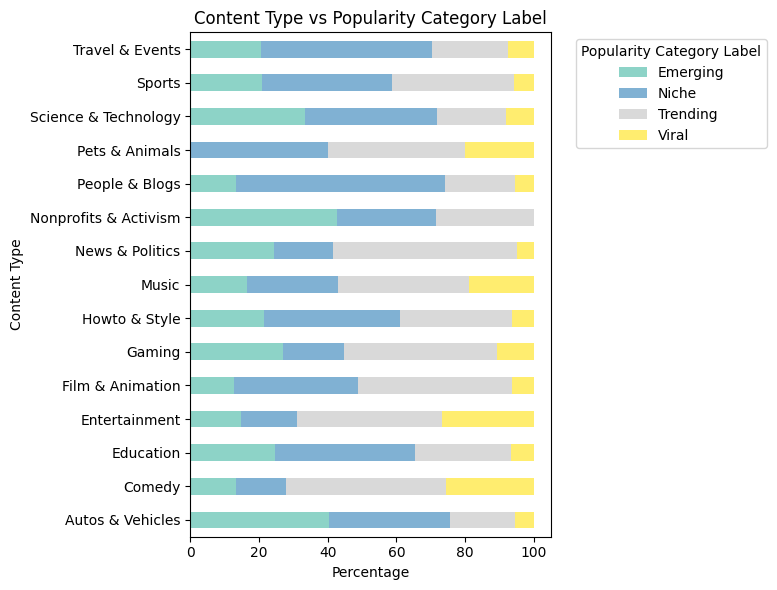

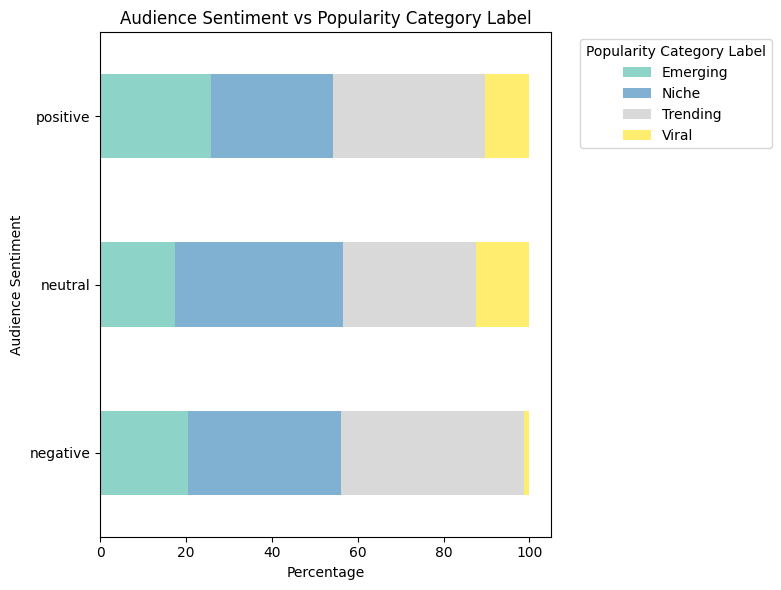

In [38]:
cat_cols = ['Content Type', 'Audience Sentiment']

for col in cat_cols:
    ct = pd.crosstab(df[col], df['Popularity Category Label'], normalize='index') * 100
    ct.plot(kind='barh', stacked=True, colormap='Set3', figsize=(8, 6))
    plt.xlabel("Percentage")
    plt.ylabel(col)
    plt.title(f'{col} vs Popularity Category Label')
    plt.legend(title='Popularity Category Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

**Heatmap**

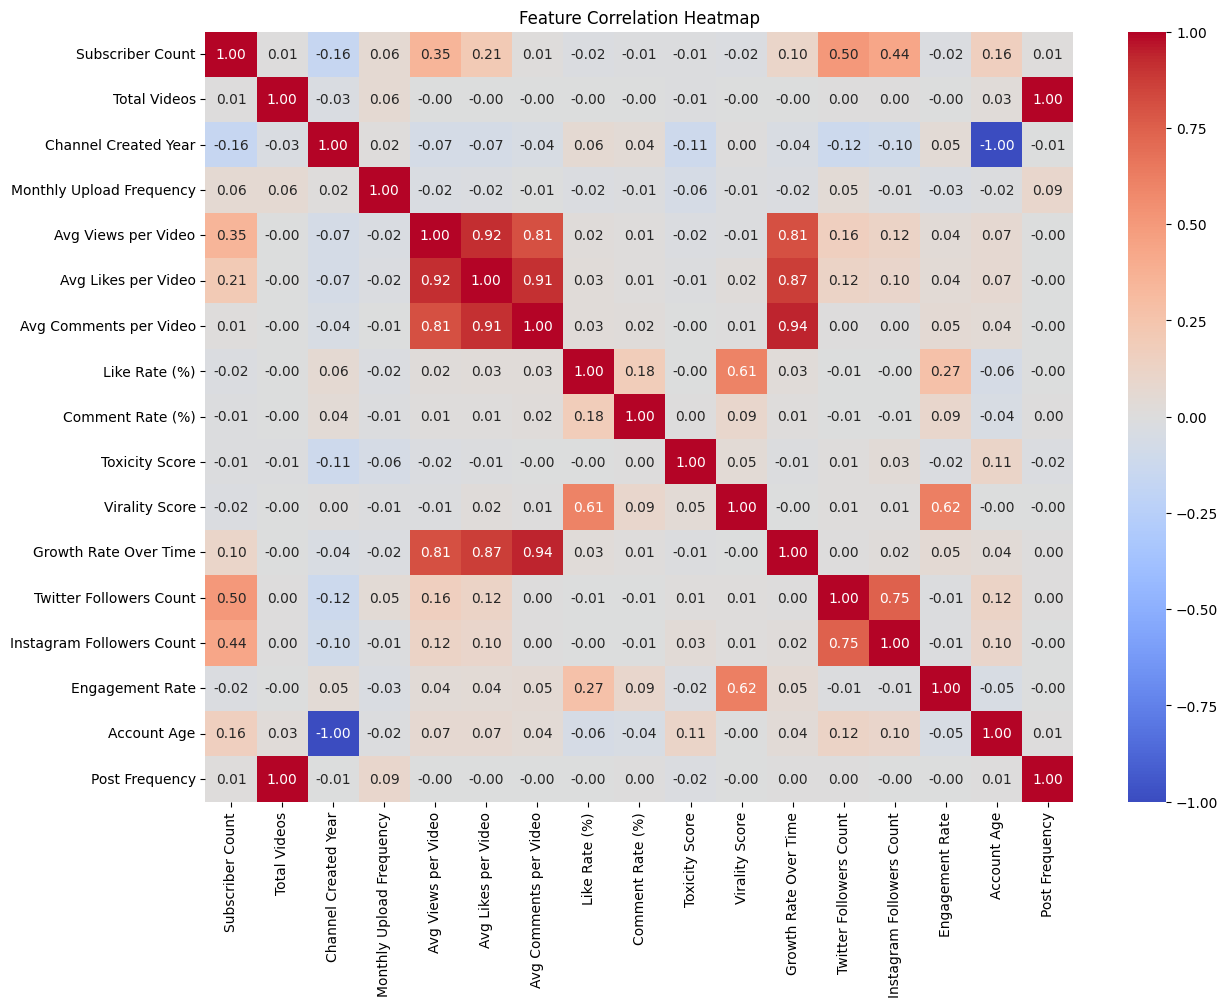

In [39]:
plt.figure(figsize=(14,10))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


**Line Plot of Channel Creation Trends**

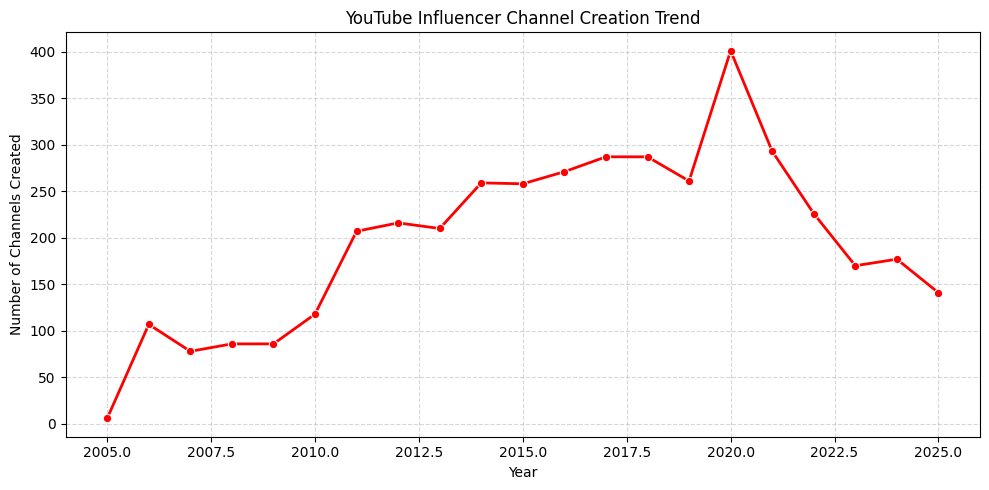

In [40]:
year_counts = df['Channel Created Year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', linewidth=2, color='red')
plt.title("YouTube Influencer Channel Creation Trend")
plt.xlabel("Year")
plt.ylabel("Number of Channels Created")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# **Multivariate Analysis**

**Pairplot: Key Features by Popularity**

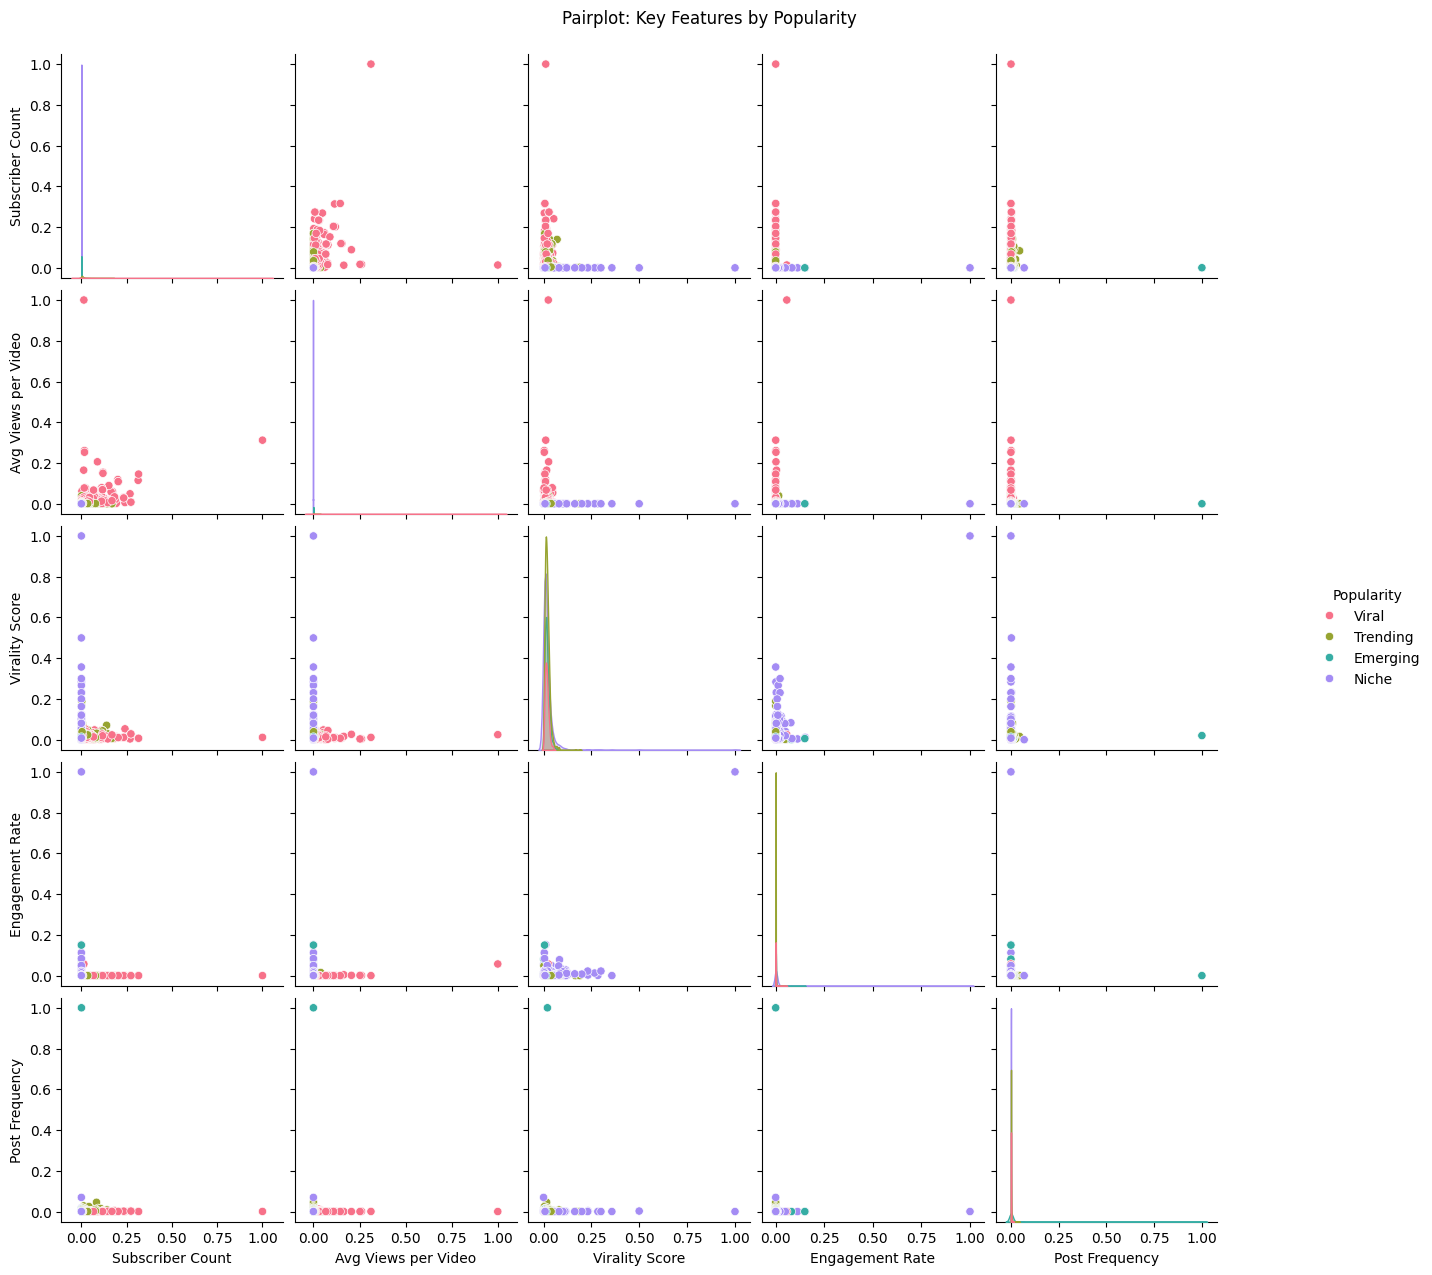

In [41]:
selected_features = ['Subscriber Count', 'Avg Views per Video', 'Virality Score',
                     'Engagement Rate', 'Post Frequency', 'Popularity Category Label']

g = sns.pairplot(df[selected_features], hue='Popularity Category Label', palette='husl', diag_kind='kde')
g.fig.suptitle("Pairplot: Key Features by Popularity", y=1.02)
g._legend.set_title("Popularity")
plt.show()


**Social Media Popularity by YouTube Popularity**

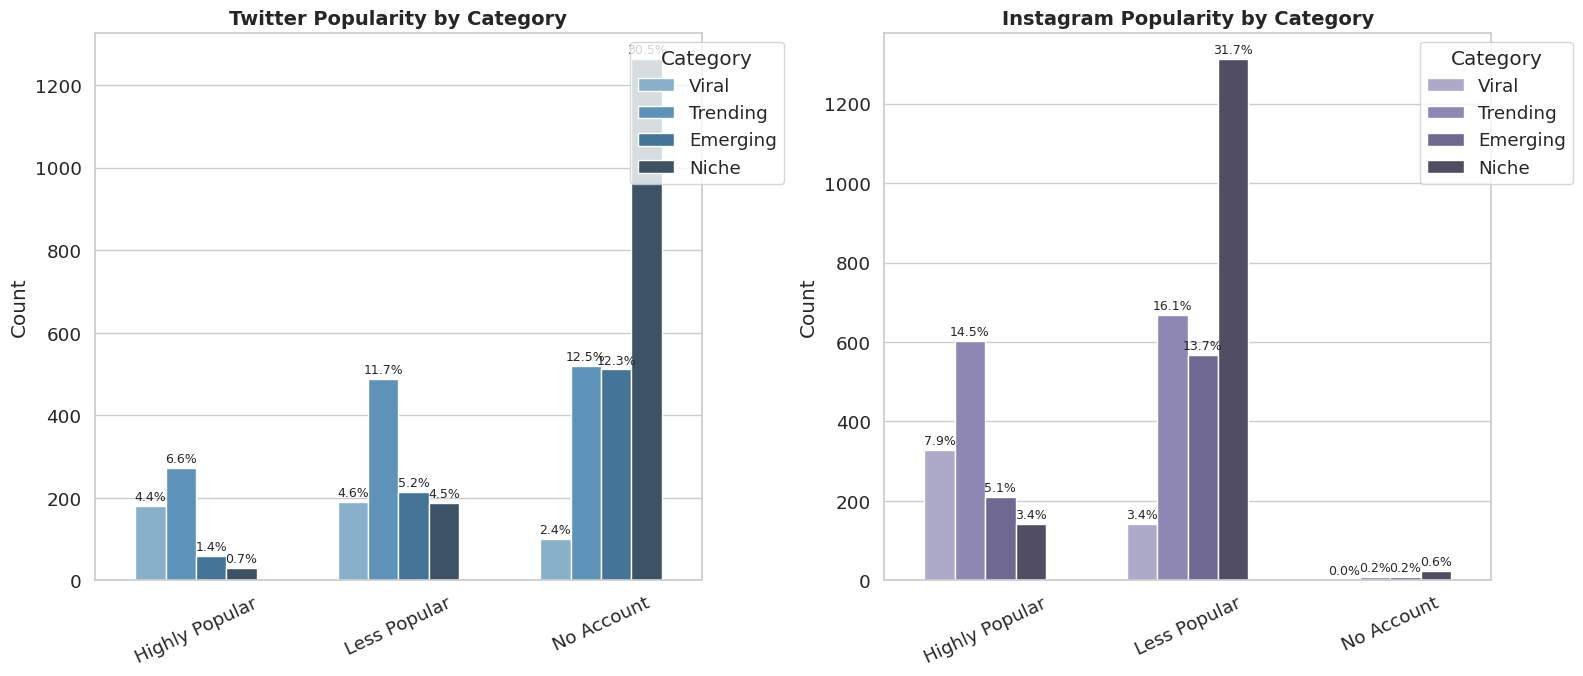

In [42]:
popular_youtube = df[df['Popularity Category Label'].isin(['Viral', 'Trending', 'Emerging', 'Niche'])].copy()
popular_youtube['Popular on Twitter'] = popular_youtube['Popular on Twitter'].str.title()
popular_youtube['Popular on Instagram'] = popular_youtube['Popular on Instagram'].str.title()

pop_order = ['Highly Popular','Less Popular', 'No Account']
hue_order = ['Viral', 'Trending', 'Emerging', 'Niche']

# Set style
sns.set(style='whitegrid', font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

def annotated_countplot(ax, platform_column, palette, title):
    plot = sns.countplot(
        data=popular_youtube,
        x=platform_column,
        hue='Popularity Category Label',
        order=pop_order,
        hue_order=hue_order,
        palette=palette,
        ax=ax,
        width=0.6
    )
    total = len(popular_youtube)
    for container in plot.containers:
        labels = [f"{(v.get_height()/total*100):.1f}%" if v.get_height() > 0 else '' for v in container]
        plot.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=2)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=25)
    ax.legend(title='Category', loc='upper right', bbox_to_anchor=(1.15, 1))

# Twitter plot
annotated_countplot(axes[0], 'Popular on Twitter', 'Blues_d', 'Twitter Popularity by Category')

# Instagram plot
annotated_countplot(axes[1], 'Popular on Instagram', 'Purples_d', 'Instagram Popularity by Category')

plt.tight_layout()
plt.show()


# **Label Encoding**

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Popularity Category Label'] = le.fit_transform(df['Popularity Category Label'])
df['Content Type'] = le.fit_transform(df['Content Type'])

In [44]:
print(df.head())

   Influencer Name Creator Country  Subscriber Count  Total Videos  \
0          MrBeast             USA          1.000000           875   
1     Stokes Twins             USA          0.313433           369   
2  Alan's Universe             USA          0.231343          1400   
3               A4             USA          0.201493          1000   
4       Mark Rober             USA          0.171642           214   

   Channel Created Year  Monthly Upload Frequency  Content Type  \
0                2012.0                       5.0             3   
1                2008.0                       1.0            10   
2                2020.0                       0.0             3   
3                2014.0                       0.0             3   
4                2011.0                       1.0            12   

   Avg Views per Video  Avg Likes per Video  Avg Comments per Video  ...  \
0             0.312082             0.143836                0.003209  ...   
1             0.114803  

# **Features Selection**

In [45]:
# **Feature Selection**
selected_features = [
    'Subscriber Count','Total Videos', 'Avg Views per Video', 'Avg Likes per Video',
    'Avg Comments per Video', 'Virality Score',
    'Growth Rate Over Time', 'Engagement Rate', 'Post Frequency',
    'Channel Created Year','Content Type', 'Toxicity Score']
target = 'Popularity Category Label'

In [46]:
df.dropna(inplace=True)

In [47]:
df.shape

(3983, 24)

Feature Selection Heatmap

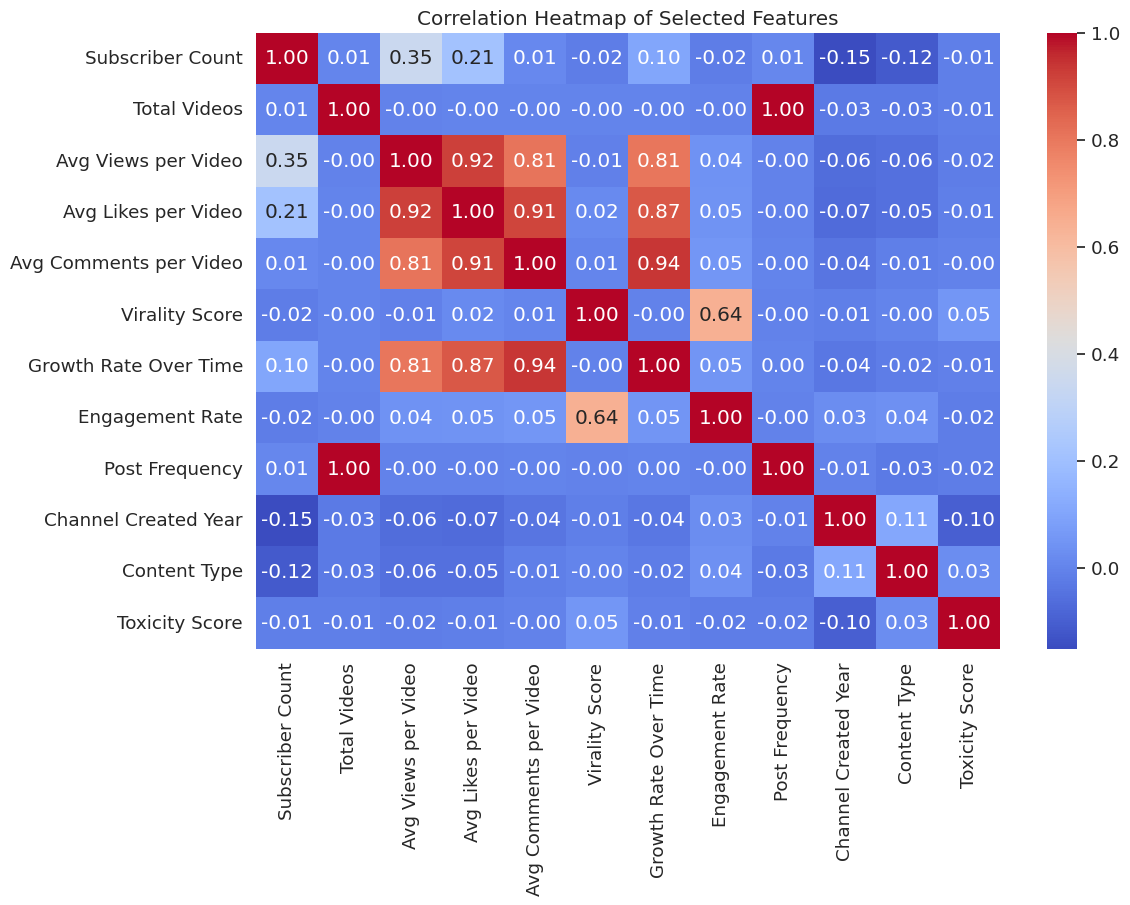

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[selected_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [49]:
X = df[selected_features]
y = df['Popularity Category Label']


**Train-Test Split**

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# **Model Selection**

**Logistic Regression**

In [51]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Accuracy: 0.479297365119197

Confusion Matrix:
 [[  0  84  76   0]
 [  3 207  62   0]
 [  0  92 175   0]
 [  0  27  71   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.50      0.76      0.61       272
           2       0.46      0.66      0.54       267
           3       0.00      0.00      0.00        98

    accuracy                           0.48       797
   macro avg       0.24      0.35      0.29       797
weighted avg       0.32      0.48      0.39       797



**SVM**

In [52]:
from sklearn.svm import SVC

svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Accuracy: 0.424090338770389

Confusion Matrix:
 [[  0 136  24   0]
 [  0 254  18   0]
 [  0 183  84   0]
 [  0  79  19   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.39      0.93      0.55       272
           2       0.58      0.31      0.41       267
           3       0.00      0.00      0.00        98

    accuracy                           0.42       797
   macro avg       0.24      0.31      0.24       797
weighted avg       0.33      0.42      0.32       797



**Decision Tree**

In [53]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Accuracy: 0.9974905897114178

Confusion Matrix:
 [[159   0   1   0]
 [  0 271   1   0]
 [  0   0 267   0]
 [  0   0   0  98]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       160
           1       1.00      1.00      1.00       272
           2       0.99      1.00      1.00       267
           3       1.00      1.00      1.00        98

    accuracy                           1.00       797
   macro avg       1.00      1.00      1.00       797
weighted avg       1.00      1.00      1.00       797



**Random Forest**

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.998745294855709

Confusion Matrix:
 [[160   0   0   0]
 [  0 271   1   0]
 [  0   0 267   0]
 [  0   0   0  98]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       272
           2       1.00      1.00      1.00       267
           3       1.00      1.00      1.00        98

    accuracy                           1.00       797
   macro avg       1.00      1.00      1.00       797
weighted avg       1.00      1.00      1.00       797



**Model Comparison**

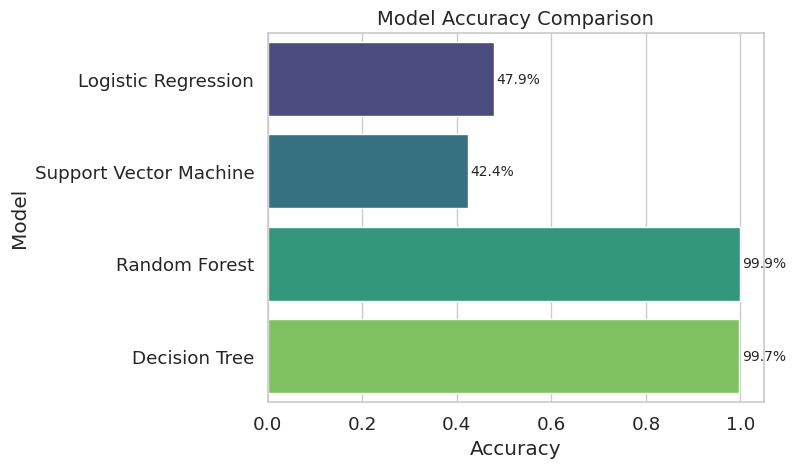

In [55]:
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine', 'Random Forest', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dt),
    ]
})

sns.barplot(data=model_comparison, x='Accuracy', y='Model', palette='viridis')

for index, row in model_comparison.iterrows():
    plt.text(row['Accuracy'] + 0.005, index, f"{row['Accuracy']*100:.1f}%", va='center', fontsize=10)

plt.title('Model Accuracy Comparison', fontsize=14)
plt.show()


**Hyper Tunning Random Forest**

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:\n", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Hyperparameters:
 {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Final Accuracy: 0.9974905897114178

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       160
           1       1.00      1.00      1.00       272
           2       0.99      1.00      1.00       267
           3       1.00      1.00      1.00        98

    accuracy                           1.00       797
   macro avg       1.00      1.00      1.00       797
weighted avg       1.00      1.00      1.00       797



Hyperparameter tuning reduced model complexity while preserving near perfect accuracy (99.7%). It resulted in a slight reduction of  accuracy after hyperparameter tuning the random forest model but it offers better generalization on new data and a lower risk of overfitting

**Pickle Model**

In [57]:
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

with open('model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

print("Scaler, Label Encoder, and Model have been saved as .pkl files.")

Scaler, Label Encoder, and Model have been saved as .pkl files.
